In [1]:
import sys
from copy import deepcopy
import numpy as np
from numpy.polynomial.chebyshev import chebfit, chebval
from scipy.optimize import fmin_cg, minimize
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian1DKernel, convolve
from linetools.spectra.xspectrum1d import XSpectrum1D
from pypit import arload

In [2]:
"""
Get wavelength-dependent resolution for LRIS R.
From P. van Dokkum's fit to the sky lines
"""

def get_lrisr_resolution(wavelength):
    """
    This comes from P. van Dokkum's fit
    to the sky lines
    """

    l9   = (wavelength - 9000.)/1000.
    resr = 1.26-0.128*l9+0.168*l9**2+0.1173*l9**3
    resr = resr/wavelength*3.E5 # km s^-1

    return np.array(resr)

In [3]:
def get_data(fname):

    tmp = arload.load_1dspec(fname, exten=1)

    data = np.zeros((len(tmp.wavelength.value), 3))
    data[:,0] = tmp.wavelength.value
    data[:,1] = tmp.flux.value
    data[:,2] = tmp.sig.value

    return data

In [4]:
def get_kernel(sp, inval=10000., outval=150):
    clight = 299792.458

    # Get FWHM of spectrum we're smoothing
    # (assuming resolution is in R)

    fwhm_in_ = sp.wavelength.value/inval
    psize    = np.diff(sp.wavelength.value)
    psize    = np.append(psize, sp.wavelength[-1].value - sp.wavelength[-2].value)

    # Get FWHM of resolution we're smooth too
    # (assuming resolution is in km/s)

    fwhm_out = outval*2.*np.sqrt(2*np.log(2))
    fwhm_out = (fwhm_out / clight) * sp.wavelength.value

    fwhm_diff = (fwhm_out - fwhm_in_)/psize

    return fwhm_diff

In [5]:
def get_transmission(data):
    """
    This transmission spectrum comes from the ESO SkyCalc,
    with default inputs.
    """

    tmp = np.loadtxt('../data/atmospheric_transmission/maunakea.dat')

    # Convert transmission spectrum to angstroms
    # and clip it to wavelength range of data
    i = ((tmp[:,0]*10 >= min(data[:,0])) &
         (tmp[:,0]*10 <= max(data[:,0])))
    trans = XSpectrum1D.from_tuple((tmp[:,0][i]*10, tmp[:,1][i]))

    # Convolve the atm. transsissiom spectrum to LRIS_R resolution
    res         = get_lrisr_resolution(trans.wavelength.value)
    fwhm_pix    = get_kernel(trans, inval=20000., outval=res)

    smooth_spec = np.zeros((len(trans.wavelength.value)))
    for i, fp in enumerate(fwhm_pix):
        tmp = trans.gauss_smooth(fp)
        smooth_spec[i] = tmp.flux.value[i]

    # Get model transmission on same wavelength grid
    # as data
    model = np.zeros((len(data[:,0]), 2))
    model[:,0] = data[:,0]
    model[:,1] = np.interp(data[:,0],
                           trans.wavelength.value, smooth_spec)

    return model

In [6]:
def get_template(theta, trans):
    return 1 + theta*(trans[:,1] - 1)

In [7]:
def lnlike_tf(theta, data, trans):

    i = ((data[:,0] >= 9320) &
         (data[:,0] <= 9380))

    tmp = get_template(theta, trans)

    """
    plt.plot(data[:,0][i], data[:,1][i], color='k')
    plt.plot(data[:,0][i], tmp[i], color='r', label=theta)
    plt.legend()
    plt.show()
    """

    return (-0.5 * np.sum(np.log(2 * np.pi * data[:,2][i]**2)
            + (data[:,1][i] - tmp[i])**2 / data[:,2][i]**2))

In [8]:
def opposite_lnlike_tf(theta, data, trans):
    return -1. * lnlike_tf(theta, data, trans)

In [9]:
def get_fscale(data, tran):

    i = ((data[:,0] >= 9250) &
         (data[:,0] <= 9650))

    coef = chebfit(data[:,0][i], data[:,1][i], 4)
    poly = chebval(data[:,0][i], coef)
    tmp_data = np.zeros((len(data[:,0][i]), 3))
    tmp_data[:,0] = data[:,0][i]
    tmp_data[:,1] = data[:,1][i]/poly
    tmp_data[:,2] = data[:,2][i]

    coef = chebfit(tran[:,0][i], tran[:,1][i], 4)
    poly = chebval(tran[:,0][i], coef)
    tmp_tran = np.zeros((len(tran[:,0][i]), 2))
    tmp_tran[:,0] = tran[:,0][i]
    tmp_tran[:,1] = tran[:,1][i]/poly

    """
    plt.plot(tmp_data[:,0], tmp_data[:,1], color='k')
    plt.plot(tmp_tran[:,0], tmp_tran[:,1], color='r')
    plt.show()
    """

    soln = minimize(opposite_lnlike_tf, 1,
                    args=(tmp_data, tmp_tran))

    return soln['x'][0]

In [10]:
%matplotlib inline

def tcorrect_data(fscale, data, tran):
    template = get_template(fscale, tran)

    tc_data      = deepcopy(data)
    tc_data[:,1] = data[:,1]/template

    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    i = ((data[:,0] >= 8050) & (data[:,0] <= 8400))
    ax1.plot(data[:,0][i], data[:,1][i]/np.median(data[:,1][i]) + 0.1,
             color='k', label='Data')
    ax1.plot(data[:,0][i], template[i]/np.median(template[i]),
             color='r', label='Atm Model')
    ax1.plot(tc_data[:,0][i], tc_data[:,1][i]/np.median(tc_data[:,1][i]) - 0.12,
             color='b', label='TC Data')

    i = ((data[:,0] >= 8900) & (data[:,0] <= 9200))
    ax2.plot(data[:,0][i], data[:,1][i]/np.median(data[:,1][i]) + 0.1,
             color='k', label='Data')
    ax2.plot(data[:,0][i], template[i]/np.median(template[i]),
             color='r', label='Atm Model')
    ax2.plot(tc_data[:,0][i], tc_data[:,1][i]/np.median(tc_data[:,1][i]) - 0.12,
             color='b', label='TC Data')

    ax1.legend()

    plt.tight_layout()

/Users/alexa/linetools/linetools/spectra/xspectrum1d.py:108: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


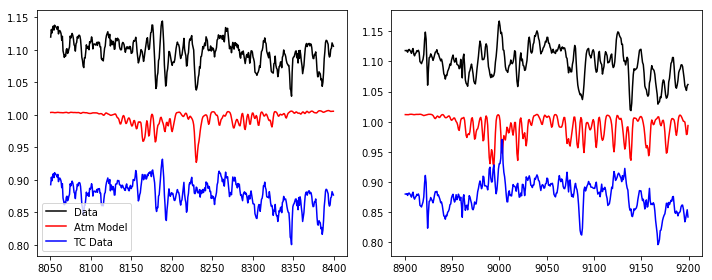

In [11]:
data = get_data('m31_b225_coadd_red.fits')
tran = get_transmission(data)
fscale = get_fscale(data, tran)
tcorrect_data(fscale, data, tran)
